<a href="https://colab.research.google.com/github/Zhuoyue-Huang/urop_2022_ml/blob/main/feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
"""Verify the gradient derivation of linear masked autoencoder."""
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import numpy as np
import pandas as pd 
import scipy.stats as stats

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
# set default to be float64
torch.set_default_dtype(torch.float64)

### Model initialisation

In [41]:
# Linear auto-encoder model
class LAE(nn.Module):
    def __init__(self, n, p):
        super(LAE, self).__init__()
        self.n = n
        self.p = p
        self.w1 = nn.Linear(n, p, bias=False)
        self.w2 = nn.Linear(p, n, bias=False)

    def forward(self, y):
        y = self.w1(y)
        y = self.w2(y)
        return y

In [42]:
## Masked lienar auto-encoder model
# Define different types of masks
def mask_basic(prob, sample_num, x_dim):
    return torch.zeros(sample_num, x_dim).bernoulli_(prob)

def mask_dropping_probs(prob_list: torch.Tensor, sample_num, x_dim):
    return torch.zeros(sample_num, x_dim).bernoulli_(prob_list)

def mask_patches_block(prob, patch_size: torch.Tensor, sample_num, sample_dim: torch.Tensor):
    x_dim = sample_dim[0]*sample_dim[1]
    div_check = sample_dim % patch_size == torch.zeros(2)
    if torch.all(div_check):
        pix_num = torch.div(sample_dim, patch_size, rounding_mode='floor')
        mat_patches = torch.zeros(sample_num, *pix_num).bernoulli_(prob)
        mat_patches = torch.repeat_interleave(mat_patches, patch_size[1], dim=2)
        return mat_patches.repeat_interleave(patch_size[0], dim=1).view(sample_num, x_dim)
    else:
        raise NotImplementedError(f"Both height ({sample_dim[0]}) and width ({sample_dim[1]}) should be divisible by patch_size ({patch_size}).")

def mask_patches_plain(prob, patch_size, sample_num, x_dim):
    if not x_dim % patch_size:
        pix_num = x_dim // patch_size
        mat_patches = torch.zeros(sample_num, pix_num).bernoulli_(prob)
        return mat_patches.repeat_interleave(patch_size, dim=1)
    else:
        raise NotImplementedError

# Masked autoencoder (linear)
class M_LAE(nn.Module):
    def __init__(self, prob, x_dim, z_dim, type='basic', patch_size=None, sample_dim=None):
        super(M_LAE, self).__init__()
        self.prob = prob
        if sample_dim is not None:
            self.sample_dim = sample_dim
            self.H, self.W = sample_dim
            self.n = self.H * self.W
        self.n = x_dim
        self.p = z_dim
        if type not in ['basic', 'probs', 'patches']:
            raise NotImplementedError("Could only implement 'basic', 'probs' and 'patches' type of masking.")
        else:
            self.masking_type = type
        if patch_size is not None:
            self.patch_size = patch_size
        w1 = nn.Linear(self.n, self.p, bias=False)
        w2 = nn.Linear(self.p, self.n, bias=False)
        self.body = nn.Sequential(*[w1, w2])
    
    def forward(self, X, mask=None):
        m = X.shape[0]
        if mask is None:
            if self.masking_type == 'basic':
                mask = mask_basic(self.prob, m, self.n).to(device)
            elif self.masking_type == 'probs':
                mask = mask_dropping_probs(self.prob, m, self.n).to(device)
            elif self.masking_type == 'patches':
                mask = mask_patches_plain(self.prob, self.patch_size, m, self.n).to(device)
        Y = mask * X
        Y = self.body(Y)
        return Y

In [43]:
class FE_Net(nn.Module):
    def __init__(self, z_dim, y_dim):
        super(FE_Net, self).__init__()
        self.theta = nn.Linear(z_dim, y_dim, bias=False)

    def forward(self, W):
        return self.theta(W)

In [44]:
def train_loop(data_dict, model, criterion, optimizer, type, epochs=10, sample_average=10, record=True):
    train_loss = []
    val_loss = []
    if type=='encoder':
        X_train = data_dict['X_train']
        y_train = X_train
    elif type=='fe':
        X_train = data_dict['X_train']
        y_train = data_dict['y_train']
        sample_average = 1

    for epoch in range(epochs+1):
        loss_total = 0
        optimizer.zero_grad()
        for i in range(sample_average):
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss_total += loss
        loss_total /= sample_average
        loss_total.backward()
        optimizer.step()
        if record:
          train_loss.append(loss_total.item())
          if epochs>=20 and epoch%(epochs//20)==0:
              v_loss = test_loop(data_dict, model, criterion, type)
              val_loss.append(v_loss)
              print('epoch: ', epoch, ', train loss: ', loss.item(), ', val loss', v_loss)
    if record:
        return {'train_loss': train_loss, 'val_loss': val_loss}
    else:
        return loss_total.item()

def test_loop(data_dict, model, criterion, type):
    if type=='encoder':
        X_val = data_dict['X_val']
        y_val = X_val
    elif type=='fe':
        X_val = data_dict['X_val']
        y_val = data_dict['y_val']

    with torch.no_grad():
        outputs = model(X_val)
        loss = criterion(outputs, y_val)
    return loss.item()

In [45]:
# feature extraction
def feature_extraction(data_dict, model_parameters, criterion, type, epochs=200, device='cuda'):
    X_train, y_train, X_val, y_val, _, _ = data_dict.values()

    params = list(model_parameters)
    W1 = params[0].clone().detach()
    train_z = X_train @ W1.T
    val_z = X_val @ W1.T
    z_dim = train_z.shape[1]
    y_dim = y_train.shape[1]

    if type=='ls':
        theta = (torch.inverse(train_z.T @ train_z) @ train_z.T @ y_train).T
        loss = criterion(y_val, val_z @ theta.T)
        return loss.item()
    elif type=='gd':
        data_dict_fe = {'X_train': train_z, 'y_train': y_train,
                        'X_val': val_z, 'y_val': y_val}
        net_fe = FE_Net(z_dim, y_dim).to(device)
        theta = list(net_fe.parameters())
        optimizer = optim.Adam(theta, lr=0.0001)
        ### TRAINING ###
        loss_fe = train_loop(data_dict_fe, net_fe, criterion, optimizer, epochs=epochs, record=False, type='fe')
        return loss_fe

### Dataset

In [83]:
train_num, val_num, test_num = (60, 20, 20)
sample_num_split = (train_num, train_num + val_num)
total = train_num+val_num+test_num

# need to consider x_dim < and > z_dim
z_dim = 30 # dimension of z
H = 8
W = 8
sample_dim = torch.tensor([H, W])
x_dim = H * W
y_dim = z_dim // 2

prob_search = torch.range(0, 1, 0.05)
prob_list_search = torch.rand(x_dim, generator=torch.random.manual_seed(1911))*0.2\
                   + torch.repeat_interleave(torch.range(0, 0.8, 0.05).unsqueeze(1), x_dim, dim=1)
patch_size_plain_search = torch.tensor([2, 4, 8, 16])
patch_size_block_search = []
for i in [2, 4, 8, 16]:
    for j in [2, 4, 8, 16]:
        patch_size_block_search.append([i, j])
patch_size_search = torch.tensor(patch_size_block_search)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  from ipykernel import kernelapp as app


In [92]:
mean = torch.linspace(0, 5, z_dim).repeat(total, 1)
std = torch.linspace(3, 8, z_dim).repeat(total, 1)
z = torch.normal(mean=mean, std=std, generator=torch.random.manual_seed(1911))
#z = torch.normal(mean=0, std=1, size=(total,z_dim), generator=torch.random.manual_seed(1911)) # here distribution is high dimensional guassian
z = z.to(device)
print(z)

tensor([[ -4.2401,   0.8917,   3.5890,  ...,  18.2923,  16.9860,   9.2572],
        [ -2.9493,   2.8546,   3.3010,  ...,  -0.5569,  11.4914,  -0.6434],
        [  1.7800,  -1.8138,  -3.0275,  ...,  13.8007,   4.2634,  -0.0749],
        ...,
        [  5.6195,   1.3791,   2.3917,  ...,   3.8568,   6.9248,  11.7555],
        [  4.3048,  -0.0330,   8.9343,  ...,   0.6828,  10.4800, -12.9735],
        [ -1.4269,  -4.1088,   3.5206,  ...,   5.1196,  -3.8657,  -5.6825]],
       device='cuda:0')


In [48]:
U = torch.rand(x_dim, z_dim, generator=torch.random.manual_seed(1911))
U = U.to(device)
V = torch.rand(y_dim, z_dim, generator=torch.random.manual_seed(1911))
V = V.to(device)

x = z @ U.T
y = z @ V.T
X_train, X_val, X_test = torch.tensor_split(x, sample_num_split)
y_train, y_val, y_test = torch.tensor_split(y, sample_num_split)
data_dict = {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val, 'X_test': X_test, 'y_test': y_test}
fe_loss_dict = {'LAE': [], 'MLAE_basic': [], 'MLAE_probs': [], 'MLAE_patches': []}

In [49]:
learning_rate = 0.01
epochs = 1000
epochs_fe = 100
epochs_grid = 5

### Get features from autoencoder

##### Linear autoencoder

In [50]:
for i in tqdm(range(epochs_fe)):
    net_LAE = LAE(x_dim, z_dim).to(device)

    params = list(net_LAE.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_LAE = train_loop(data_dict, net_LAE, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_LAE, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_LAE.parameters(), criterion, type='ls', epochs=epochs)
    loss_ls = feature_extraction(data_dict, net_LAE.parameters(), criterion, type='ls', epochs=epochs)
    fe_loss_dict['LAE'].append(loss_ls)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:  0 , train loss:  10.75418529651003 , val loss 7.18901058600618
epoch:  50 , train loss:  0.7080410841574116 , val loss 1.0714952697197118
epoch:  100 , train loss:  0.24135456076989825 , val loss 0.5274104243594536
epoch:  150 , train loss:  0.120080444200453 , val loss 0.3437893348000173
epoch:  200 , train loss:  0.09571922144216483 , val loss 0.259419700051626
epoch:  250 , train loss:  0.048295665194353785 , val loss 0.1790956673649702
epoch:  300 , train loss:  0.0322141114454895 , val loss 0.13647345538508074
epoch:  350 , train loss:  0.021802493503695185 , val loss 0.10412886141400882
epoch:  400 , train loss:  0.01742770035254835 , val loss 0.07896677799946605
epoch:  450 , train loss:  0.010532599509938517 , val loss 0.059344066646572546
epoch:  500 , train loss:  0.007641300251185898 , val loss 0.04505618316147705
epoch:  550 , train loss:  0.005766991726172073 , val loss 0.03463724704573149
epoch:  600 , train loss:  0.004481851944178366 , val loss 0.026775687694072

100%|██████████| 100/100 [06:46<00:00,  4.07s/it]


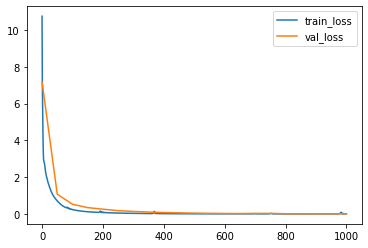

In [51]:
plt.plot(loss_LAE['train_loss'])
plt.plot(range(0, epochs+1, epochs//20), loss_LAE['val_loss'])
plt.legend(loss_LAE.keys())

In [52]:
print('mean:', statistics.mean(fe_loss_dict['LAE']), ', sd:', statistics.stdev(fe_loss_dict['LAE']))

mean: 7.981267277054154e-18 , sd: 7.592882303516115e-17


##### Masked linear autoencoder (basic)

In [53]:
# grid search
search_score = []
search_record = {'params': -1, 'best_score': 1e8}

for prob in tqdm(prob_search):
    for i in range(epochs_grid):
        loss = 0

        net_MLAE_basic = M_LAE(prob, x_dim, z_dim).to(device)

        params = list(net_MLAE_basic.parameters())
        criterion = nn.MSELoss()
        optimizer = optim.Adam(params, lr=learning_rate)

        ### TRAINING ###
        if i==0 and prob==0.75:
            loss_MLAE_basic = train_loop(data_dict, net_MLAE_basic, criterion, optimizer, epochs=epochs, record=True, type='encoder')
        else:
            train_loop(data_dict, net_MLAE_basic, criterion, optimizer, epochs=epochs, record=False, type='encoder')
        loss += test_loop(data_dict, net_MLAE_basic, criterion, type='encoder')

    loss /= epochs_grid
    search_score.append(loss)
    if loss < search_record['best_score']:
        search_record['best_score'] = loss
        search_record['params'] = prob

 71%|███████▏  | 15/21 [07:26<02:56, 29.35s/it]

epoch:  0 , train loss:  11.180587408283337 , val loss 8.402849041816728
epoch:  50 , train loss:  1.2224402198764073 , val loss 1.591993752106995
epoch:  100 , train loss:  0.8134064885531146 , val loss 1.1951297048292253
epoch:  150 , train loss:  0.8180348305550817 , val loss 1.1091913705837333
epoch:  200 , train loss:  0.8267463697755087 , val loss 1.1484186863317947
epoch:  250 , train loss:  0.7799212290841944 , val loss 0.9996089855161254
epoch:  300 , train loss:  0.8859898082498321 , val loss 1.0692352959412028
epoch:  350 , train loss:  0.7675666339887754 , val loss 1.0420148894920593
epoch:  400 , train loss:  0.7686247989112127 , val loss 1.0505763328297935
epoch:  450 , train loss:  0.7430032031586394 , val loss 1.0143133295857687
epoch:  500 , train loss:  0.7412194363571993 , val loss 1.007953420687327
epoch:  550 , train loss:  0.7728382005970853 , val loss 0.978727355660968
epoch:  600 , train loss:  0.8196251371046839 , val loss 1.024540901462286
epoch:  650 , train 

100%|██████████| 21/21 [10:17<00:00, 29.42s/it]


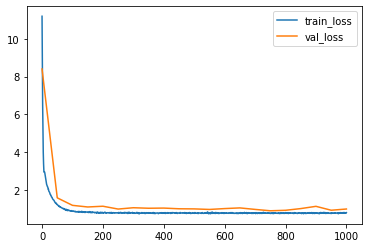

In [54]:
# training check at prob is 0.75
plt.plot(loss_MLAE_basic['train_loss'])
plt.plot(range(0, epochs+1, epochs//20), loss_MLAE_basic['val_loss'])
plt.legend(loss_MLAE_basic.keys())

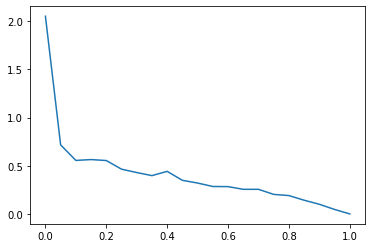

In [55]:
# search check
plt.plot(prob_search, search_score)

In [56]:
prob = search_record['params']
print('prob:', prob.item(), '\nloss:', loss)

prob: 1.0 
loss: 0.0017853411300354726


In [57]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_basic = M_LAE(prob, x_dim, z_dim).to(device)

    params = list(net_MLAE_basic.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    train_loop(data_dict, net_MLAE_basic, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_basic.parameters(), criterion, type='ls', epochs=epochs)
    loss_ls = feature_extraction(data_dict, net_MLAE_basic.parameters(), criterion, type='ls', epochs=epochs)
    fe_loss_dict['MLAE_basic'].append(loss_ls)

100%|██████████| 100/100 [09:19<00:00,  5.59s/it]


In [58]:
print('mean:', statistics.mean(fe_loss_dict['MLAE_basic']), ', sd:', statistics.stdev(fe_loss_dict['MLAE_basic']))

mean: 1.2104658900235374e-19 , sd: 7.057202146729156e-19


##### Masked linear autoencoder (probs)

In [59]:
# grid search
search_score = []
search_record = {'params': -1, 'best_score': 1e8}

for count, prob_list in tqdm(enumerate(prob_list_search)):
    for i in range(epochs_grid):
        loss = 0

        net_MLAE_probs = M_LAE(prob_list, x_dim, z_dim, type='probs').to(device)

        params = list(net_MLAE_probs.parameters())
        criterion = nn.MSELoss()
        optimizer = optim.Adam(params, lr=learning_rate)

        ### TRAINING ###
        if i==0 and count==15:
            loss_MLAE_probs = train_loop(data_dict, net_MLAE_probs, criterion, optimizer, epochs=epochs, record=True, type='encoder')
        else:
            train_loop(data_dict, net_MLAE_probs, criterion, optimizer, epochs=epochs, record=False, type='encoder')
        loss += test_loop(data_dict, net_MLAE_probs, criterion, type='encoder')

    loss /= epochs_grid
    search_score.append(loss)
    if loss < search_record['best_score']:
        search_record['best_score'] = loss
        search_record['params'] = prob_list

15it [07:16, 28.97s/it]

epoch:  0 , train loss:  11.958497053804585 , val loss 8.719763842554508
epoch:  50 , train loss:  1.0485685407523337 , val loss 1.4442497237064669
epoch:  100 , train loss:  0.6772833209576934 , val loss 1.0382380008296506
epoch:  150 , train loss:  0.6308260277476218 , val loss 0.9238193616727758
epoch:  200 , train loss:  0.5964615642916056 , val loss 0.9027407502853386
epoch:  250 , train loss:  0.4756464611713217 , val loss 0.6956216901071143
epoch:  300 , train loss:  0.5096608601816001 , val loss 0.6902835851221216
epoch:  350 , train loss:  0.4957750304626945 , val loss 0.7115506867943648
epoch:  400 , train loss:  0.5188508600362485 , val loss 0.6686706710385638
epoch:  450 , train loss:  0.5068271179576033 , val loss 0.6465186391406655
epoch:  500 , train loss:  0.5004240019972229 , val loss 0.7315938135325103
epoch:  550 , train loss:  0.47217402975842426 , val loss 0.6840628772829974
epoch:  600 , train loss:  0.5035488504920455 , val loss 0.6162967539753957
epoch:  650 , t

17it [08:14, 29.08s/it]


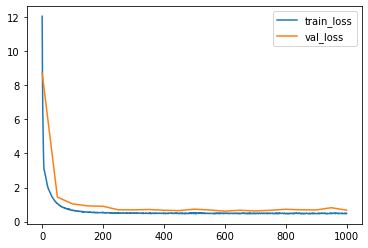

In [60]:
# training check at prob is 0.75
plt.plot(loss_MLAE_probs['train_loss'])
plt.plot(range(0, epochs+1, epochs//20), loss_MLAE_probs['val_loss'])
plt.legend(loss_MLAE_probs.keys())

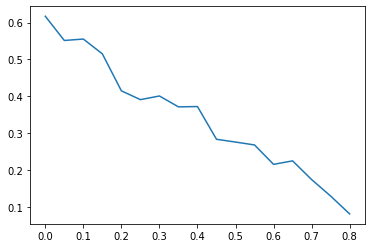

In [61]:
# search check
plt.plot(list(prob_search)[:17], search_score)

In [62]:
prob_list = search_record['params']
print('prob:', prob_list, '\nloss:', loss)

prob: tensor([0.9429, 0.9029, 0.8814, 0.8644, 0.8603, 0.8468, 0.9667, 0.9169, 0.8851,
        0.8440, 0.8102, 0.8919, 0.9371, 0.8715, 0.8871, 0.9910, 0.9719, 0.8529,
        0.8122, 0.9602, 0.9517, 0.8467, 0.9217, 0.8747, 0.8003, 0.9097, 0.8994,
        0.8459, 0.8373, 0.8260, 0.9255, 0.8661, 0.9166, 0.8724, 0.9880, 0.8690,
        0.9982, 0.9198, 0.9367, 0.8836, 0.9733, 0.8724, 0.9421, 0.9831, 0.8926,
        0.8811, 0.9513, 0.8992, 0.8926, 0.8419, 0.8757, 0.8663, 0.8828, 0.8803,
        0.9237, 0.8387, 0.8314, 0.9536, 0.8338, 0.9712, 0.8195, 0.9788, 0.9259,
        0.9502]) 
loss: 0.08078506544590627


In [63]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_probs = M_LAE(prob_list, x_dim, z_dim, type='probs').to(device)

    params = list(net_MLAE_probs.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    train_loop(data_dict, net_MLAE_probs, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_probs.parameters(), criterion, type='ls', epochs=epochs)
    loss_ls = feature_extraction(data_dict, net_MLAE_probs.parameters(), criterion, type='ls', epochs=epochs)
    fe_loss_dict['MLAE_probs'].append(loss_ls)

100%|██████████| 100/100 [09:29<00:00,  5.70s/it]


In [64]:
print('mean:', statistics.mean(fe_loss_dict['MLAE_probs']), ', sd:', statistics.stdev(fe_loss_dict['MLAE_probs']))

mean: 7.36806316646596e-18 , sd: 5.3870552688851267e-17


##### Masked linear autoencoder (patches)

In [65]:
# grid search
search_score = []
search_record = {'params': -1, 'best_score': 1e8}

for prob in tqdm(prob_search):
    for patch_size in patch_size_plain_search:
        for i in range(epochs_grid):
            loss = 0

            net_MLAE_patches = M_LAE(prob, x_dim, z_dim, type='patches', patch_size=patch_size).to(device)

            params = list(net_MLAE_patches.parameters())
            criterion = nn.MSELoss()
            optimizer = optim.Adam(params, lr=lr)

            ### TRAINING ###
            if i==0 and prob==0.75 and patch_size==8:
                loss_MLAE_patches = train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=True, type='encoder')
            else:
                train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=False, type='encoder')
            loss += test_loop(data_dict, net_MLAE_patches, criterion, type='encoder')

        loss /= epochs_grid
        search_score.append(loss)
        if loss < search_record['best_score']:
            search_record['best_score'] = loss
            search_record['params'] = (prob, patch_size)

 71%|███████▏  | 15/21 [32:22<13:02, 130.48s/it]

epoch:  0 , train loss:  12.603099992395455 , val loss 8.69344371530073
epoch:  50 , train loss:  1.4871235226063237 , val loss 1.9912973056461838
epoch:  100 , train loss:  0.7888070885283313 , val loss 1.2556447829881607
epoch:  150 , train loss:  0.6516166830797434 , val loss 1.136431737811361
epoch:  200 , train loss:  0.6761241839965161 , val loss 1.462487619067819
epoch:  250 , train loss:  0.5567312980077747 , val loss 0.7438302714793813
epoch:  300 , train loss:  0.5772048692861562 , val loss 0.7240951976966274
epoch:  350 , train loss:  0.4987293943740743 , val loss 0.9794380898282807
epoch:  400 , train loss:  0.6192155620408697 , val loss 0.6141467058376148
epoch:  450 , train loss:  0.5677350385956397 , val loss 0.7147200516763773
epoch:  500 , train loss:  0.5377586672874345 , val loss 1.008732343768527
epoch:  550 , train loss:  1.0869146958399551 , val loss 0.6122017407247269
epoch:  600 , train loss:  0.5664993904215022 , val loss 0.7394916150657007
epoch:  650 , train 

100%|██████████| 21/21 [45:21<00:00, 129.61s/it]


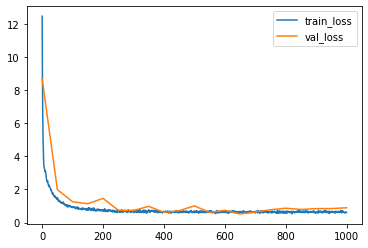

In [66]:
# training check at prob is 0.75
plt.plot(loss_MLAE_patches['train_loss'])
plt.plot(range(0, epochs+1, epochs//20), loss_MLAE_patches['val_loss'])
plt.legend(loss_MLAE_patches.keys())

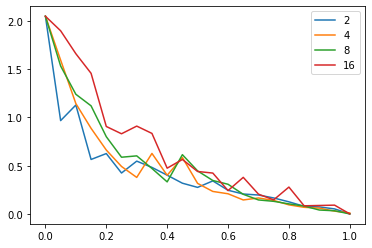

In [67]:
# search check
for i in range(4):
    plt.plot(prob_search, search_score[i::4])
plt.legend([str(patch_size.item()) for patch_size in patch_size_plain_search])

In [68]:
prob, patch_size = search_record['params']
print('prob:', prob_list, ',\npatch_size:', patch_size.item(), ',\nloss:', loss)

prob: tensor([0.9429, 0.9029, 0.8814, 0.8644, 0.8603, 0.8468, 0.9667, 0.9169, 0.8851,
        0.8440, 0.8102, 0.8919, 0.9371, 0.8715, 0.8871, 0.9910, 0.9719, 0.8529,
        0.8122, 0.9602, 0.9517, 0.8467, 0.9217, 0.8747, 0.8003, 0.9097, 0.8994,
        0.8459, 0.8373, 0.8260, 0.9255, 0.8661, 0.9166, 0.8724, 0.9880, 0.8690,
        0.9982, 0.9198, 0.9367, 0.8836, 0.9733, 0.8724, 0.9421, 0.9831, 0.8926,
        0.8811, 0.9513, 0.8992, 0.8926, 0.8419, 0.8757, 0.8663, 0.8828, 0.8803,
        0.9237, 0.8387, 0.8314, 0.9536, 0.8338, 0.9712, 0.8195, 0.9788, 0.9259,
        0.9502]) ,
patch_size: 16 ,
loss: 0.0013652427575665334


In [76]:
# feature extraction
fe_loss_dict['MLAE_patches'] = []
patch_size = 4
for i in tqdm(range(epochs_fe)):
    net_MLAE_patches = M_LAE(prob, x_dim, z_dim, type='patches', patch_size=patch_size).to(device)

    params = list(net_MLAE_patches.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='ls', epochs=epochs)
    loss_ls = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='ls', epochs=epochs)
    fe_loss_dict['MLAE_patches'].append(loss_ls)

100%|██████████| 100/100 [09:58<00:00,  5.99s/it]


In [77]:
print('mean:', statistics.mean(fe_loss_dict['MLAE_patches']), ', sd:', statistics.stdev(fe_loss_dict['MLAE_patches']))

mean: 1.5285811545394609e-19 , sd: 9.56344215830624e-19


### Evaluation

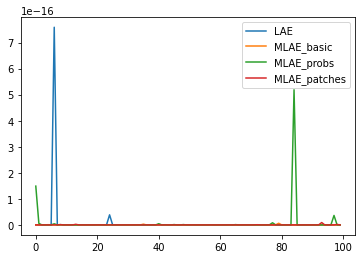

In [78]:
plt.plot(fe_loss_dict['LAE'])
plt.plot(fe_loss_dict['MLAE_basic'])
plt.plot(fe_loss_dict['MLAE_probs'])
plt.plot(fe_loss_dict['MLAE_patches'])
plt.legend(['LAE', 'MLAE_basic', 'MLAE_probs', 'MLAE_patches'])

In [79]:
fe_stats_dict = {'LAE': {'mean': statistics.mean(fe_loss_dict['LAE']), 'sd': statistics.stdev(fe_loss_dict['LAE'])},
                 'MLAE_basic': {'mean': statistics.mean(fe_loss_dict['MLAE_basic']), 'sd': statistics.stdev(fe_loss_dict['MLAE_basic'])},
                 'MLAE_probs': {'mean': statistics.mean(fe_loss_dict['MLAE_probs']), 'sd': statistics.stdev(fe_loss_dict['MLAE_probs'])},
                 'MLAE_patches': {'mean': statistics.mean(fe_loss_dict['MLAE_patches']), 'sd': statistics.stdev(fe_loss_dict['MLAE_patches'])}}
print(fe_stats_dict)

{'LAE': {'mean': 7.981267277054154e-18, 'sd': 7.592882303516115e-17}, 'MLAE_basic': {'mean': 1.2104658900235374e-19, 'sd': 7.057202146729156e-19}, 'MLAE_probs': {'mean': 7.36806316646596e-18, 'sd': 5.3870552688851267e-17}, 'MLAE_patches': {'mean': 1.5285811545394609e-19, 'sd': 9.56344215830624e-19}}


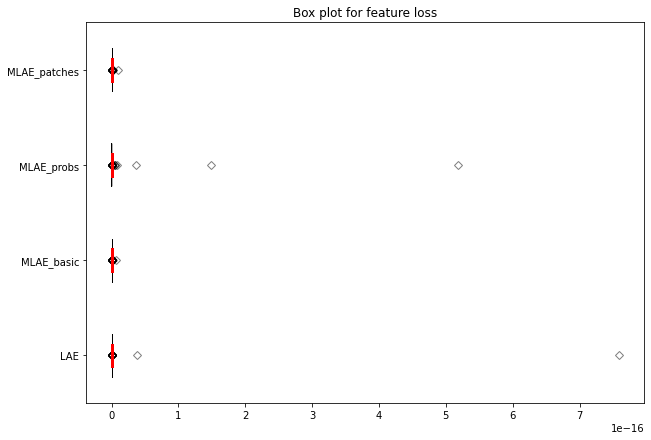

In [80]:
data = fe_loss_dict.values()
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 0)
 
colors = ['#0000FF', '#00FF00',
          '#FFFF00', '#FF00FF']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_yticklabels(fe_loss_dict.keys())
#ax.set_yticklabels(patch_dict.keys())
 
# Adding title
plt.title("Box plot for feature loss")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()